In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from bisect import bisect_left
from tqdm import tqdm
from scipy.optimize import curve_fit

In [35]:
from sklearn.preprocessing import StandardScaler

In [2]:
df_sample = pd.read_csv('player_sample.csv')

In [3]:
df_sample.head()

,Age,Previous App Purchases,Price
0,37,218,6.0
1,34,247,6.0
2,19,15,4.0
3,32,235,7.0
4,19,15,2.5


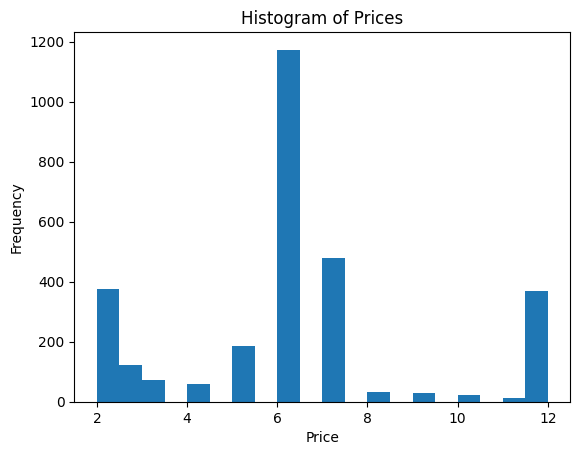

In [10]:
df_sample['Price'].plot.hist(bins=20) 

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')

plt.show()

**Question 1**

---


Suppose that Monteviu wishes to offer a single price for all players. Based on the data and the prescriptive analytics tools that we saw in class, propose a price that maximizes the expected revenue considering the total player base (i.e., 2,000,000).

In [23]:
#drop all pirces that are NA
price_dropna = df_sample.dropna(subset=['Price'])

***note:*** I droped the NAs because all players in this list were offered similar (i.e., substitutable) booster packs to the new one proposed here during their various gaming sessions, each at different prices. The players with NA did not make any purchases so I assumed that they will not purchase at any prices.

In [24]:
price_dropna

,Age,Previous App Purchases,Price
0,37,218,6.0
1,34,247,6.0
2,19,15,4.0
3,32,235,7.0
4,19,15,2.5
...,...,...,...
9984,19,11,2.0
9985,24,195,6.0
9986,35,273,6.0
9993,34,254,6.0


In [29]:
def calculate_expected_revenue(price):
    # Calculate the expected revenue based on the given price and player data
    num_players = len(price_dropna[price_dropna['Price'] >= price])
    expected_revenue = num_players * price
    return expected_revenue

In [30]:
# Define the range of prices to simulate
min_price = 1.0
max_price = 12.0
num_prices = 12
prices = np.linspace(min_price, max_price, num=num_prices)

# Initialize a dictionary to store the results
price_revenue = {}

# Simulate different pricing scenarios
for price in prices:
    expected_revenue = calculate_expected_revenue(price)
    price_revenue[price] = expected_revenue

# Find the price with the maximum expected revenue
optimal_price = max(price_revenue, key=price_revenue.get)
max_revenue = price_revenue[optimal_price]

# Print the results
print("Price\t\tExpected Revenue")
for price, revenue in price_revenue.items():
    print(f"{price}\t\t{revenue}")

print("\nOptimal Price:", optimal_price)
print("Maximum Expected Revenue:", max_revenue)

Price		Expected Revenue
1.0		2932.0
2.0		5864.0
3.0		7296.0
4.0		9440.0
5.0		11505.0
6.0		12696.0
7.0		6601.0
8.0		3712.0
9.0		3870.0
10.0		4000.0
11.0		4169.0
12.0		4416.0

Optimal Price: 6.0
Maximum Expected Revenue: 12696.0


In [33]:
def calculate_expected_revenue(price):
    # Calculate the expected revenue based on the given price and player data
    num_players = len(price_dropna[price_dropna['Price'] >= price])
    expected_revenue = num_players * price
    return expected_revenue, num_players

# Define the range of prices to simulate
min_price = 1.0
max_price = 12.0
num_prices = 12
prices = np.linspace(min_price, max_price, num=num_prices)

# Initialize a dictionary to store the results
price_revenue = {}
num_buyers = {}

# Simulate different pricing scenarios
for price in prices:
    expected_revenue, num_players = calculate_expected_revenue(price)
    price_revenue[price] = expected_revenue
    num_buyers[price] = num_players

# Find the price with the maximum expected revenue
optimal_price = max(price_revenue, key=price_revenue.get)
max_revenue = price_revenue[optimal_price]

# Print the results
print("Price\t\tExpected Revenue\t\tNumber of Buyers")
for price, revenue in price_revenue.items():
    num_players = num_buyers[price]
    print(f"{price}\t\t{revenue}\t\t{num_players}")

print("\nOptimal Price:", optimal_price)
print("Maximum Expected Revenue:", max_revenue)


Price		Expected Revenue		Number of Buyers
1.0		2932.0		2932
2.0		5864.0		2932
3.0		7296.0		2432
4.0		9440.0		2360
5.0		11505.0		2301
6.0		12696.0		2116
7.0		6601.0		943
8.0		3712.0		464
9.0		3870.0		430
10.0		4000.0		400
11.0		4169.0		379
12.0		4416.0		368

Optimal Price: 6.0
Maximum Expected Revenue: 12696.0


In [49]:
# current estimate is based on the 10,000 sample size, apply it to the 2,000,000 player base:
total_revenue_q1 = 12696.0*200
print("\nOptimal revenue for entire player base:", total_revenue_q1)


Optimal revenue for entire player base: 2539200.0


**Question 2**

---


Suppose now that Monteviu can offer a different price per player. While a player is in-game, Monteviu observes the player demographics and can select a personalized price they will experience accordingly. Based on your predictive and prescriptive knowledge from the MMA courses and supply chain optimization, develop an efficient mechanism for personalized pricing that maximizes revenue. What insights do you obtain in this mechanism, i.e., can prices change significantly per person? Moreover, what is the increase in expected revenue compared to the single-price option?

In [36]:
#kmeans clustering
features = price_dropna[['Age', 'Previous App Purchases']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters
# Perform the necessary analysis (elbow method, silhouette analysis, etc.)

# Apply K-means clustering
k = 3  # Update with the optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(scaled_features)

# Get the cluster labels for each player
cluster_labels = kmeans.labels_

# Add cluster labels to the original DataFrame
price_dropna['Cluster'] = cluster_labels

# Analyze the clusters
cluster_analysis = price_dropna.groupby('Cluster').mean()
print(cluster_analysis)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


               Age  Previous App Purchases      Price
Cluster                                              
0        31.301788              239.999474   6.152997
1        17.375000               14.526667   2.356667
2        64.862791              119.288372  11.632558


<ipython-input-36-8c586b07102b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_dropna['Cluster'] = cluster_labels


In [38]:
price_dropna

,Age,Previous App Purchases,Price,Cluster
0,37,218,6.0,0
1,34,247,6.0,0
2,19,15,4.0,1
3,32,235,7.0,0
4,19,15,2.5,1
...,...,...,...,...
9984,19,11,2.0,1
9985,24,195,6.0,0
9986,35,273,6.0,0
9993,34,254,6.0,0


In [37]:
cluster_analysis

,Age,Previous App Purchases,Price
Cluster,,,
0,31.301788,239.999474,6.152997
1,17.375000,14.526667,2.356667
2,64.862791,119.288372,11.632558


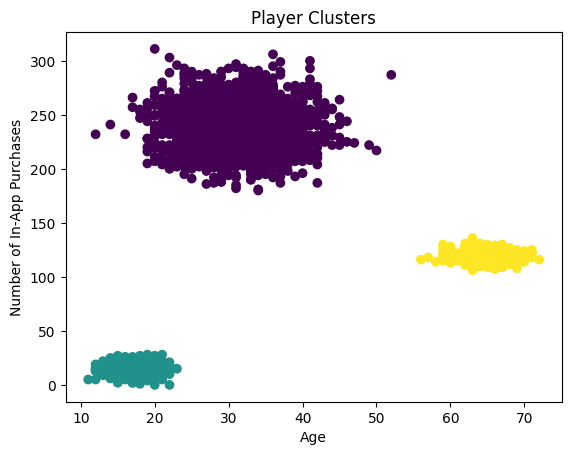

In [48]:
# Visualize the clusters
plt.scatter(price_dropna['Age'], price_dropna['Previous App Purchases'], c=price_dropna['Cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Number of In-App Purchases')
plt.title('Player Clusters')
plt.show()

In [45]:
def calculate_expected_revenue_1(price, cluster):
    # Calculate the expected revenue based on the given price and player data
    num_players = len(price_dropna[(price_dropna['Price'] >= price) & (price_dropna['Cluster'] == cluster)])
    expected_revenue = num_players * price
    return expected_revenue, num_players

# Initialize dictionaries to store the results for each cluster
cluster_price_revenue = {}
cluster_num_buyers = {}

# Simulate different pricing scenarios for each cluster
for cluster in [0,1,2]:  # 'k' represents the number of clusters
    price_revenue = {}
    num_buyers = {}

    for price in prices:
        expected_revenue, num_players = calculate_expected_revenue_1(price, cluster)
        price_revenue[price] = expected_revenue
        num_buyers[price] = num_players

    # Store the results for the cluster
    cluster_price_revenue[cluster] = price_revenue
    cluster_num_buyers[cluster] = num_buyers

# Find the best price and maximum expected revenue for each cluster
cluster_optimal_prices = {}
cluster_max_revenues = {}

for cluster in range(k):
    price_revenue = cluster_price_revenue[cluster]
    num_buyers = cluster_num_buyers[cluster]
    optimal_price = max(price_revenue, key=price_revenue.get)
    max_revenue = price_revenue[optimal_price]

    # Store the results for the cluster
    cluster_optimal_prices[cluster] = optimal_price
    cluster_max_revenues[cluster] = max_revenue

# Print the results for each cluster
print("Cluster\tOptimal Price\tMaximum Expected Revenue")
for cluster in range(k):
    optimal_price = cluster_optimal_prices[cluster]*200
    max_revenue = cluster_max_revenues[cluster]*200
    print(f"{cluster}\t{optimal_price}\t\t{max_revenue}")

Cluster	Optimal Price	Maximum Expected Revenue
0	1200.0		2011200.0
1	400.0		240000.0
2	2400.0		883200.0
